# Casualties Clasification

RSA DCC Dublin Dataset (Random Forest, Nive Bayes, SVC) with Gid search for hyperparameters

# Outcome  Prediction 
- Data preparation
- Model building and evaluation


### 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rsa import RsaGaussianNB, RsaSupportVector, RandomForest

sns.set_palette("tab10")
sns.color_palette()

# hide warnings
import warnings
warnings.filterwarnings('ignore')
sns.set_theme();

C:\Users\rmsry\anaconda3\envs\geo_env\lib\site-packages\pyproj\__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


Testing epsg_900913_to_4326....
Testing haversine_distance....
Setting color pallete to tab10...


In [2]:
# reading the dataset
dcc_df_final_csv = "rsa/data/dcc_df_final.csv"
rsa_dcc = pd.read_csv(dcc_df_final_csv,index_col=0)

In [3]:
rsa_dcc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5245 entries, 0 to 5327
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           5245 non-null   int64  
 1   year                         5245 non-null   int64  
 2   weekday                      5245 non-null   int64  
 3   hour                         5245 non-null   int64  
 4   splimit                      5245 non-null   int64  
 5   gender                       5245 non-null   int64  
 6   age                          5245 non-null   int64  
 7   county                       5245 non-null   int64  
 8   vehicle_type                 5245 non-null   int64  
 9   circumstances                5245 non-null   int64  
 10  latitude                     5245 non-null   float64
 11  longitude                    5245 non-null   float64
 12  total_casualties             5245 non-null   float64
 13  outcome_calculated

In [4]:
rsa_dcc.head()

,id,year,weekday,hour,splimit,gender,age,county,vehicle_type,circumstances,...,outcome_calculated,is_fatal,severity,knn_cluster,fbs_distance_m,fbs_station,fbs_estimated_response_time,is_gosafe,radius_500m,safety_index
0,79928,2016,7,4,50,1,6,6,1,10,...,3,False,0.0,1,1765.472596,2,12.862480,True,81,0.274914
1,83409,2016,3,3,50,1,8,6,6,1,...,3,False,0.0,5,1460.494119,2,10.640537,True,128,0.436426
2,83183,2016,6,1,50,2,8,6,3,1,...,3,False,0.0,0,732.343359,1,6.566647,True,72,0.243986
3,83108,2016,2,3,50,2,5,6,3,6,...,3,False,0.0,6,2473.486573,5,20.208375,True,35,0.116838
4,80345,2016,5,5,30,1,7,6,5,1,...,3,False,0.0,5,723.822684,0,7.779222,True,141,0.481100


In [5]:
#remove rebundant column county. Only DCC included
if 'county' in rsa_dcc.columns:
    rsa_dcc.drop(columns=['county'], inplace=True)

In [6]:
rsa_dcc['outcome_calculated'].astype('category').value_counts()

3    4847
2     348
1      50
Name: outcome_calculated, dtype: int64

In [7]:
# Check for null
rsa_dcc.isnull().sum()

id                             0
year                           0
weekday                        0
hour                           0
splimit                        0
gender                         0
age                            0
vehicle_type                   0
circumstances                  0
latitude                       0
longitude                      0
total_casualties               0
outcome_calculated             0
is_fatal                       0
severity                       0
knn_cluster                    0
fbs_distance_m                 0
fbs_station                    0
fbs_estimated_response_time    0
is_gosafe                      0
radius_500m                    0
safety_index                   0
dtype: int64

In [8]:
# Drop rows with no severity
rsa_dcc = rsa_dcc.drop(rsa_dcc[rsa_dcc.severity.isnull()].index)

In [9]:
# Check for null
rsa_dcc.isnull().sum()

id                             0
year                           0
weekday                        0
hour                           0
splimit                        0
gender                         0
age                            0
vehicle_type                   0
circumstances                  0
latitude                       0
longitude                      0
total_casualties               0
outcome_calculated             0
is_fatal                       0
severity                       0
knn_cluster                    0
fbs_distance_m                 0
fbs_station                    0
fbs_estimated_response_time    0
is_gosafe                      0
radius_500m                    0
safety_index                   0
dtype: int64

In [10]:
rsa_dcc.columns

Index(['id', 'year', 'weekday', 'hour', 'splimit', 'gender', 'age',
       'vehicle_type', 'circumstances', 'latitude', 'longitude',
       'total_casualties', 'outcome_calculated', 'is_fatal', 'severity',
       'knn_cluster', 'fbs_distance_m', 'fbs_station',
       'fbs_estimated_response_time', 'is_gosafe', 'radius_500m',
       'safety_index'],
      dtype='object')

In [11]:
# Checking for outliers in the continuous variables
rsa_dcc_numeric = rsa_dcc[['latitude', 'longitude', 'radius_500m', 'safety_index', 'fbs_distance_m']]

In [12]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%
rsa_dcc_numeric.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,latitude,longitude,radius_500m,safety_index,fbs_distance_m
count,5245.000000,5245.000000,5245.000000,5245.000000,5245.000000
mean,53.348501,-6.265413,89.857388,0.305352,1425.042069
std,0.022583,0.035264,71.806040,0.246756,831.922760
min,53.302152,-6.385915,1.000000,0.000000,5.778145
25%,53.331585,-6.284762,34.000000,0.113402,827.168846
50%,53.345280,-6.264842,65.000000,0.219931,1283.919247
75%,53.361173,-6.245282,135.000000,0.460481,1827.718788
90%,53.384454,-6.222463,197.000000,0.673540,2568.372895
95%,53.393156,-6.205872,253.000000,0.865979,3140.757630
99%,53.401826,-6.173467,283.560000,0.970997,3897.702506


> Radius is imbalance interms of concentration of accidents in the city center. A similar imbalance dataset can be seen when comparing non serious and serious accidents.

## Upscaling and resamble dataset to improve imbalanced data

There is no correlation between the variables with the exception of is fatal. Given that the Dataset is imbalanced and most of the incidents are Minor injured = Low Severity, it will be explain the correlation to this column. However this is not sufficient for regresion models where correlation is important such as Linear, Ridge or Lasso. Naïve Bayes classifier 

REF: van der Walt, Christiaan & Barnard, Etienne. (2007). Data characteristics that determine classifier performance. SAIEE Africa Research Journal. 98. 10.23919/SAIEE.2007.9488132. 

### Option 1: Bootstrap Resampling with replacement on minority of the class
The bootstrap is aresampling method for statistical inference.

In [13]:
from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = rsa_dcc[(rsa_dcc['severity']==0)] 
df_minority = rsa_dcc[(rsa_dcc['severity']==1)] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= df_majority.shape[0], # match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])


In [14]:
df_upsampled['severity'].astype('category').value_counts()

0.0    4847
1.0    4847
Name: severity, dtype: int64

### Option 2: SMOTE (Synthetic Minority Over-sampling Technique) is based on the k-nearest
https://link.springer.com/content/pdf/10.1186/s13040-021-00283-6.pdf

SMOTE (Synthetic Minority Over-sampling Technique) is based on the k-nearest
neighbor algorithm [25]. First, it finds the k-nearest neighbors in the minority class for
each of the samples in the class. Then it draws a line between the neighbors and generates random points on the lines. We used SMOTE with default settings, i.e., the number of k-nearest neighbors is set to 5.

In [15]:
from imblearn.over_sampling import SMOTE
# Resampling the minority class.
sm = SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=5)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(rsa_dcc.drop('severity', axis=1), rsa_dcc['severity'])
df_upsampled_smote = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

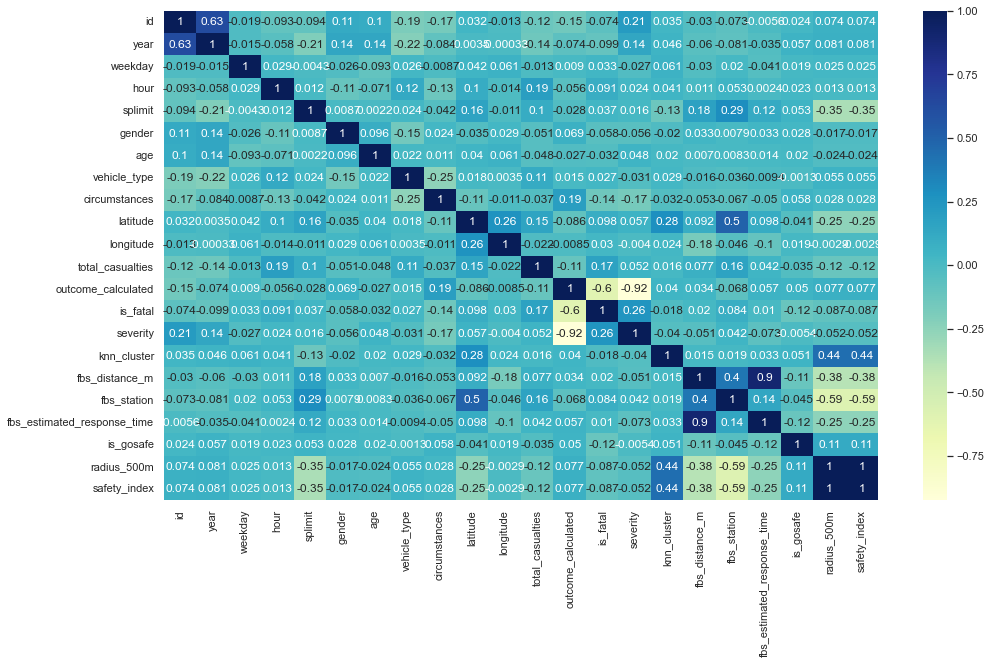

In [16]:
plt.figure(figsize = (16,9))
sns.heatmap(df_upsampled.corr(), annot = True, cmap="YlGnBu");

<Figure size 1152x648 with 0 Axes>

<AxesSubplot:>

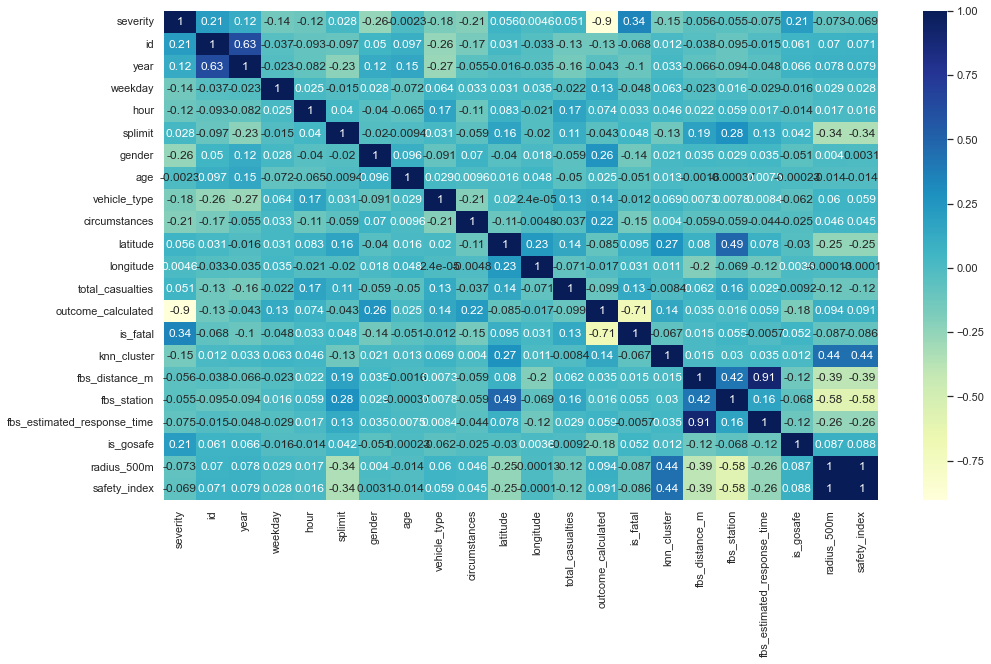

In [17]:
plt.figure(figsize = (16,9))
sns.heatmap(df_upsampled_smote.corr(), annot = True, cmap="YlGnBu");
plt.savefig("rsa/visualization/images/img18_rsa_heatmap.png")

array([[<AxesSubplot:title={'center':'severity'}>,
        <AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'weekday'}>],
       [<AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'splimit'}>,
        <AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'vehicle_type'}>,
        <AxesSubplot:title={'center':'circumstances'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>],
       [<AxesSubplot:title={'center':'total_casualties'}>,
        <AxesSubplot:title={'center':'outcome_calculated'}>,
        <AxesSubplot:title={'center':'knn_cluster'}>,
        <AxesSubplot:title={'center':'fbs_distance_m'}>],
       [<AxesSubplot:title={'center':'fbs_station'}>,
        <AxesSubplot:title={'center':'fbs_estimated_response_time'}>,
        <AxesSubplot:title={'center':'radi

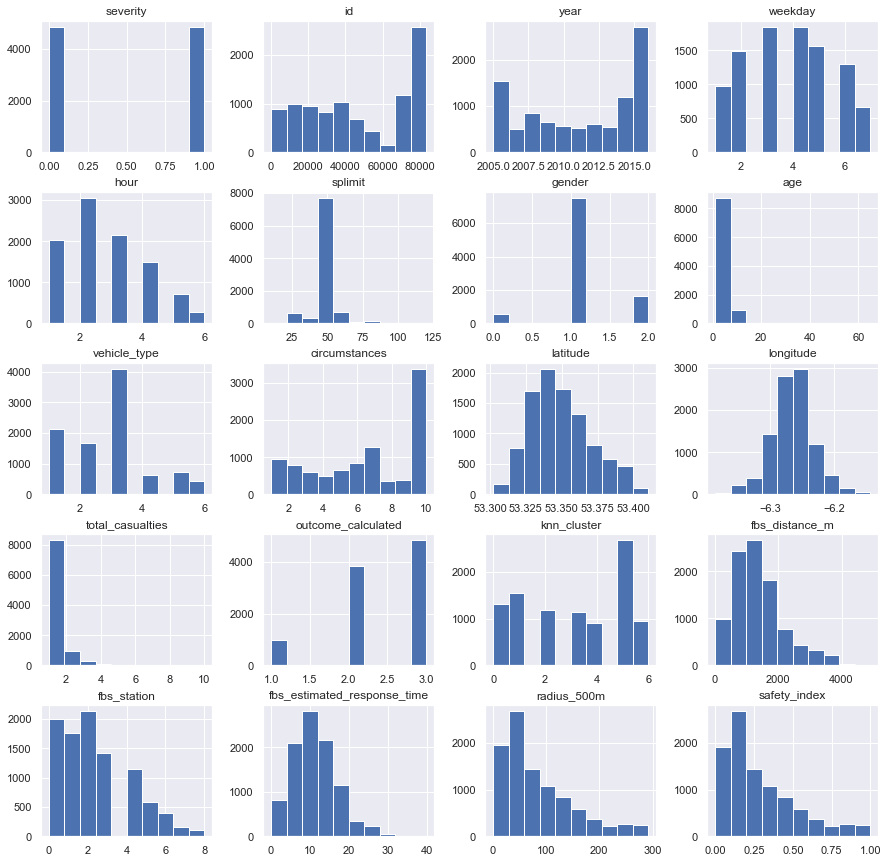

In [18]:
fig = plt.figure(figsize = (15,15)) # Size of the figure
ax = fig.gca()                                
df_upsampled_smote.hist(ax = ax)          # draw a histogram based on the dataset
plt.show()

In [19]:
# split into X and y
X =  df_upsampled_smote.loc[:, ['year', 'weekday', 'hour', 'splimit', 'gender', 'age',
       'vehicle_type', 'circumstances', 'latitude', 'longitude',
       'total_casualties', 'knn_cluster', 'fbs_distance_m', 'fbs_station',
       'fbs_estimated_response_time', 'is_gosafe', 'safety_index']]

y = df_upsampled_smote['severity']
(X.shape,y.shape)

((9694, 17), (9694,))

# RadomForest

In [20]:
rf = RandomForest(X, y)
rf.ScaleModel()
rf.Predict()
rf.ConfusionMatrix()


accuracy 0.9355337802991233
precision 0.9402677651905252
recall 0.9316326530612244


array([[901,  58],
       [ 67, 913]], dtype=int64)

In [21]:
rf.ProbabilityPrection()

Threshold 0.2 -- 0.8015790257708924
Threshold 0.25 -- 0.8443654103977358
Threshold 0.3 -- 0.878809772084016
Threshold 0.35 -- 0.8997988976612543
Threshold 0.39999999999999997 -- 0.9212200208550574
Threshold 0.44999999999999996 -- 0.9333345747057948
Threshold 0.49999999999999994 -- 0.935554148666766
Threshold 0.5499999999999999 -- 0.9351668404588112
Threshold 0.6 -- 0.9348353940116192
Threshold 0.65 -- 0.9237338000893788
Threshold 0.7000000000000001 -- 0.9079845076716818
Threshold 0.7500000000000001 -- 0.8876210338149859
---Optimum Threshold --- 0.49999999999999994 --ROC-- 0.935554148666766


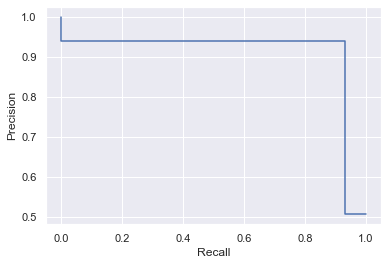

In [22]:
rf.PlotPrecisionRecall()

In [23]:
rf.CrossValidation().mean()

0.697154085371049

In [24]:
rf.ParameterTunning()

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [25]:
# printing the optimal accuracy score and hyperparameters
best_score = rf.model_cv.best_score_
best_hyperparams = rf.model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9186331399097357 corresponding to hyperparameters {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


# Naive Bayes

In [26]:
gnb = RsaGaussianNB(X, y)
gnb.ScaleModel()
gnb.Predict()
gnb.ConfusionMatrix()

accuracy 0.7106756059824652
precision 0.6934441366574331
recall 0.7663265306122449


array([[627, 332],
       [229, 751]], dtype=int64)

In [27]:
# Find an accuracy from the confusion matrix.
cm = gnb.ConfusionMatrix()
rowsCols = cm.shape
corrPred = 0
falsePred = 0

for row in range(rowsCols[0]):
    for col in range(rowsCols[1]):
        if row == col:
            corrPred += cm[row, col]
        else:
            falsePred += cm[row, col]
print('Correct predictions: ', corrPred)
print('False predictions', falsePred)
print ('\n\nAccuracy of the Naive Bayes Clasification is: ', corrPred/(cm.sum()))      

Correct predictions:  1378
False predictions 561


Accuracy of the Naive Bayes Clasification is:  0.7106756059824652


In [28]:
gnb.ParameterTunning()

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [29]:
# cv results
gnb.cv_results.sort_values(by=["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_priors,param_var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003760,0.000428,0.001039,0.000179,None,0.0,"{'priors': None, 'var_smoothing': 1e-08}",0.702772,0.687943,0.714378,...,0.704578,0.009365,1,0.704868,0.707447,0.701644,0.702289,0.707286,0.704707,0.002425
1,0.003513,0.000494,0.000790,0.000395,None,0.0,"{'priors': None, 'var_smoothing': 1e-09}",0.702772,0.687943,0.714378,...,0.704578,0.009365,1,0.704868,0.707447,0.701644,0.702289,0.707286,0.704707,0.002425
2,0.001396,0.001739,0.000197,0.000395,None,0.0,"{'priors': None, 'var_smoothing': 1e-08}",0.702772,0.687943,0.714378,...,0.704578,0.009365,1,0.704868,0.707447,0.701644,0.702289,0.707286,0.704707,0.002425


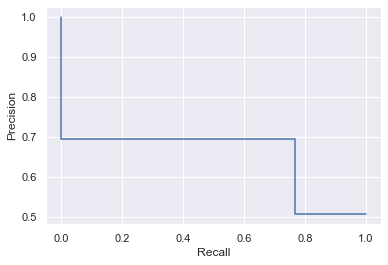

In [30]:
gnb.PlotPrecisionRecall()

## Cross validation

In [31]:
gnb.CrossValidation().mean()

0.5362000511203886

In [32]:
# printing the optimal accuracy score and hyperparameters
best_score = gnb.model_cv.best_score_
best_hyperparams = gnb.model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.7045776918117344 corresponding to hyperparameters {'priors': None, 'var_smoothing': 1e-08}


# Support Vector Classficiation

In [33]:
from rsa import RsaSupportVector

In [34]:
svc = RsaSupportVector(X, y)

In [35]:
# Scale model
svc.ScaleModel()

accuracy 0.8855079938112429
precision 0.864423076923077
recall 0.9173469387755102


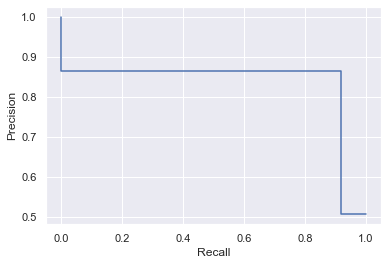

In [36]:
# Fit and predict
svc.Predict()
svc.PlotPrecisionRecall()

#https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec

## Grid Search to Find Optimal Hyperparameters

Tuning parameter to improve precission and recall

In [37]:
svc.ParameterTunning()
# cv results
svc.cv_results.sort_values(by=["rank_test_score"])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
9,2.372485,0.079109,0.487670,0.023329,100,0.01,"{'C': 100, 'gamma': 0.01}",0.848485,0.850419,0.874275,...,0.856093,0.009523,1,0.890716,0.890554,0.888298,0.891360,0.888298,0.889845,0.001292
6,1.791767,0.212370,0.770293,0.171701,10,0.01,"{'C': 10, 'gamma': 0.01}",0.818827,0.829142,0.853643,...,0.829142,0.013119,2,0.845261,0.846551,0.846873,0.848485,0.844133,0.846260,0.001479
10,1.876777,0.067456,0.655912,0.012149,100,0.001,"{'C': 100, 'gamma': 0.001}",0.782076,0.795616,0.816892,...,0.794713,0.011935,3,0.804159,0.800935,0.797711,0.800774,0.801741,0.801064,0.002068
3,1.406759,0.040577,0.595934,0.020216,1,0.01,"{'C': 1, 'gamma': 0.01}",0.770471,0.781431,0.806576,...,0.785687,0.011738,4,0.797066,0.791586,0.787395,0.796583,0.793520,0.793230,0.003544
7,1.776687,0.021824,0.789693,0.077546,10,0.001,"{'C': 10, 'gamma': 0.001}",0.739523,0.739523,0.767247,...,0.747776,0.010439,5,0.750161,0.753224,0.745487,0.752901,0.751289,0.750613,0.002793
0,1.637341,0.027800,0.716096,0.016948,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.724694,0.731141,0.748549,...,0.735010,0.007812,6,0.739684,0.739684,0.733075,0.739362,0.737427,0.737847,0.002529
11,1.805555,0.016026,0.772100,0.032081,100,0.0001,"{'C': 100, 'gamma': 0.0001}",0.722760,0.718246,0.743391,...,0.729078,0.008596,7,0.734526,0.736944,0.730013,0.733720,0.735493,0.734139,0.002326
4,1.634139,0.019793,0.689320,0.009177,1,0.001,"{'C': 1, 'gamma': 0.001}",0.707930,0.718246,0.735654,...,0.721986,0.009058,8,0.727917,0.726144,0.718085,0.725661,0.722598,0.724081,0.003453
8,1.897932,0.022240,0.834581,0.057467,10,0.0001,"{'C': 10, 'gamma': 0.0001}",0.702772,0.718891,0.733075,...,0.719278,0.009809,9,0.727595,0.723082,0.717279,0.721470,0.721148,0.722115,0.003338
1,2.134570,0.221986,0.949812,0.020399,0.1,0.001,"{'C': 0.1, 'gamma': 0.001}",0.693101,0.709865,0.722115,...,0.709994,0.009506,10,0.715184,0.713572,0.707124,0.712121,0.709220,0.711444,0.002918


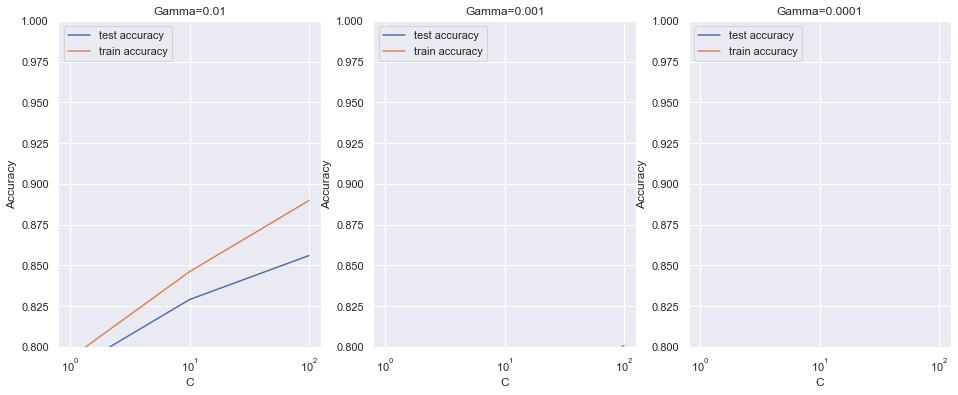

In [38]:
svc.plot_parameters_tuning()

In [39]:
# printing the optimal accuracy score and hyperparameters
best_score = svc.model_cv.best_score_
best_hyperparams = svc.model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.856092843326886 corresponding to hyperparameters {'C': 100, 'gamma': 0.01}


In [40]:
svc.CrossValidation().mean()

0.697154085371049